In [7]:
# Enable autoreload
%load_ext autoreload
%autoreload 2

import csv
from data_preparation  import preprocess_field_data, prepro_data_kl
from hsic import HSIC
import json
import matplotlib.pyplot as plt
from mcmc_integration import BayesCalibrationMCMC
from metamodels import VPCEMetamodel, KarhunenLoeveMetamodel, GpMetamodelInd
import numpy as np
import openturns as ot
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pickle
import pandas as pd


BASE_DIRECTORY = '/Users/edgarjaber/Desktop/Articles/codes folder/Bayes-calibration-for-clogging-prognostics/DATA/'
SIMULATION_TIME = np.load(BASE_DIRECTORY + 'simulation_data/LHS/d8/t_gv.npy', allow_pickle=True)

csv_file = BASE_DIRECTORY + 'field_data/field_data.csv'
input_dic = json.load(open(BASE_DIRECTORY + 'meta_data/SG_cleaning_conditioning.json'))
cleaning_dates = [input_dic['chemistry']['cleaning'][i]['time']/24 for i in range(len(input_dic['chemistry']['cleaning']))]

plt.rcParams['figure.dpi']= 300
plt.rcParams['text.usetex'] = True

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
def kl_div(a, b):
    return np.sum(np.where(a != 0, a * np.log(a / b), 0))

# Methodology implementation

In [9]:
mc_hl = np.load(BASE_DIRECTORY + 'simulation_data/MC/d8/doe_hl.npy', allow_pickle=True)
mc_cl = np.load(BASE_DIRECTORY + 'simulation_data/MC/d8/doe_cl.npy', allow_pickle=True)

n_max = mc_hl.shape[0]
n_samp = 1000
input_dimension = 8


In [10]:
#Base metamodel
X, y, SCALER = prepro_data_kl(mc_hl, mc_cl, n_max, n_samp, input_dimension, scale=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, random_state=42)
GP = GpMetamodelInd(trend='Constant', kernel='AbsExp', input_dimension=(input_dimension-1))
full_metamodel = KarhunenLoeveMetamodel(metamodel=GP, input_dimension=input_dimension, simulation_time=SIMULATION_TIME)
full_metamodel.fit(X_train, y_train)

11 nan trajectories in output sample
Running Karhunen-Loeve decomposition
Explained variance for 2 modes is 0.999998157762496
Done fitting mode 1
Done fitting mode 2


In [11]:
#Individual variable scalers
x, _ = prepro_data_kl(mc_hl, mc_cl, n_max, n_samp, input_dimension, scale=False)
scalers = []
for i in range(x.shape[1]):
    scaler = StandardScaler()
    scaler.fit(x[:,i].reshape(-1,1))
    scalers.append(scaler)

11 nan trajectories in output sample


In [12]:
#Prior distributions
alpha = ot.Uniform(100.0, 103.0)
beta = ot.Uniform(0.02, 0.025)
eps_e = ot.Uniform(0.2, 0.5)
eps_c = ot.Uniform(0.01, 0.3)
d_p = ot.Uniform(0.5e-6, 10.0e-6)
g_p0 = ot.Uniform(1.0e-9, 8.0e-9)
a_v = ot.Uniform(0.0, 15e-4)

marginals = [alpha, beta, eps_e, eps_c, d_p, g_p0, a_v]

prior = ot.ComposedDistribution(marginals)

In [13]:
data_without_time_division, _ = preprocess_field_data(csv_file=csv_file, 
                                operation_time=SIMULATION_TIME, 
                                cleaning_dates=cleaning_dates, 
                                with_time_division=False)

data_with_time_division, time_indices = preprocess_field_data(csv_file=csv_file,
                                operation_time=SIMULATION_TIME, 
                                cleaning_dates=cleaning_dates, 
                                with_time_division=True)

In [14]:
threshold = 1e-7
N = 10000

#Metamodels 
TRENDS = ['Constant', 'Linear', 'Quad']
COVS = ['AbsExp', 'SqExp', 'M-1/2', 'M-3/2', 'M-5/2']

#MCMC parameters
step_sizes = [10, 0.01, 0.01, 0.005, 5e-6, 1.5e-9, 1e-3]
proposal_distribution = [ot.Uniform(-step, step) for step in step_sizes]

while True:
    
    y_interpolated = np.asarray([np.interp(data_without_time_division[:,0]*24, SIMULATION_TIME*24, y[i,:]) for i in range(len(y))])

    X_train, X_test, y_train_int, y_test_int = train_test_split(X, y_interpolated, train_size=0.75, random_state=42)
    
    #Compute the HSIC index
    hsic = HSIC(ot.Sample(X), ot.Sample(y))
    r2_hsic, _ = hsic.r2_hsic()
    index = int(np.where(max(r2_hsic.mean(axis=1)) == r2_hsic.mean(axis=1))[0][0])
    print('HSIC max is for index = ', (index+1))

    # Compute all the calibration metamodels
    print('Computing calibration metamodels')
    metamodels = []
    for trend in TRENDS:
        for cov in COVS:
            GP = GpMetamodelInd(trend=trend, kernel=cov, input_dimension=(input_dimension-1), index=index)
            KL_calibration = KarhunenLoeveMetamodel(metamodel=GP, input_dimension=input_dimension, simulation_time=data_without_time_division[:,0]*24, verbose=False)
            KL_calibration.fit(X_train, y_train_int)
            metamodels.append(KL_calibration)
    
    # MCMC posterior distribution
    all_scalers = [scalers[int(index)]]*(len(metamodels))

    print('Running MCMC calibration')
    bayes_int = BayesCalibrationMCMC(data=data_with_time_division[0], data_time_indices=time_indices[0], metamodels=metamodels, scalers=all_scalers)

    posterior = bayes_int.mcmc_run(support_min=[marginals[index].getRange().getLowerBound()[0]], support_max=[marginals[index].getRange().getUpperBound()[0]], proposal=proposal_distribution[index], burning=100, n_chains=3, sample_size=1000, nb_weights=1000)

    # Compute the Kullback divergence
    posterior_samples = np.asarray(posterior.getSample(N)).reshape(-1)
    prior_samples = np.asarray(marginals[index].getSample(N)).reshape(-1)
    
    posterior_pdf, _ = np.histogram(posterior_samples, bins=100, density=True)
    prior_pdf, _ = np.histogram(prior_samples, bins=100, density=True)
    
    posterior_pdf = posterior_pdf / np.sum(posterior_pdf)
    prior_pdf = prior_pdf / np.sum(prior_pdf)
    
    kullback_divergence = kl_div(posterior_pdf, prior_pdf)#.sum()
    print('Kullback-Leibler divergence = ', kullback_divergence)

    if kullback_divergence < threshold or kullback_divergence == np.inf:
        #the prior is fully informed by the data and the calibration is stopped
        break

    elif kullback_divergence > threshold:
        #modify the prior distribution
        marginals[index] = posterior
        prior = ot.ComposedDistribution(marginals)
        X = np.asarray(prior.getSample(n_max))
        #Update the scalers
        scalers = []
        for i in range(X.shape[1]):
            scaler = StandardScaler()
            scaler.fit(X[:,i].reshape(-1,1))
            scalers.append(scaler)
        #Update the design of experiments
        X = SCALER.transform(X)
        y = full_metamodel.predict(X)
        continue

HSIC max is for index =  7
Computing calibration metamodels


WRN - (previous message repeated 10 times)
WRN - TNC algorithm failed. The error message is Linear search failed
WRN - Warning! For coherency we set scale upper bounds = [6.90359,6.82222,6.98139,7.00814,6.82393,6.86245,6.9168]


Running MCMC calibration
Running Markov chain 0
Running Markov chain 1
Running Markov chain 2
Gelman-Rubin convergence diagnostic: 1.0061307847216294
Kullback-Leibler divergence =  1.4143630279367798


/var/folders/gk/qw58r90s5mxbbktrp1w2mnth0000gp/T/ipykernel_3057/1849261530.py:2: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(a != 0, a * np.log(a / b), 0))
/var/folders/gk/qw58r90s5mxbbktrp1w2mnth0000gp/T/ipykernel_3057/1849261530.py:2: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(a != 0, a * np.log(a / b), 0))


HSIC max is for index =  6
Computing calibration metamodels


WRN - (previous message repeated 7 times)
WRN - Warning! For coherency we set scale upper bounds = [6.91655,6.82472,6.96884,7.02296,6.81789,6.90526,2.36627]


Running MCMC calibration
Running Markov chain 0
Running Markov chain 1
Running Markov chain 2
Gelman-Rubin convergence diagnostic: 0.9997859422730984
Kullback-Leibler divergence =  0.6141744299300094


/var/folders/gk/qw58r90s5mxbbktrp1w2mnth0000gp/T/ipykernel_3057/1849261530.py:2: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(a != 0, a * np.log(a / b), 0))
/var/folders/gk/qw58r90s5mxbbktrp1w2mnth0000gp/T/ipykernel_3057/1849261530.py:2: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(a != 0, a * np.log(a / b), 0))


HSIC max is for index =  5
Computing calibration metamodels


WRN - (previous message repeated 14 times)
WRN - Warning! For coherency we set scale upper bounds = [6.92117,6.82824,6.97087,6.93956,6.83144,2.34722,2.49096]


Running MCMC calibration
Running Markov chain 0
Running Markov chain 1
Running Markov chain 2
Gelman-Rubin convergence diagnostic: 1.0021848613268098
Kullback-Leibler divergence =  0.8039927470042857


/var/folders/gk/qw58r90s5mxbbktrp1w2mnth0000gp/T/ipykernel_3057/1849261530.py:2: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(a != 0, a * np.log(a / b), 0))
/var/folders/gk/qw58r90s5mxbbktrp1w2mnth0000gp/T/ipykernel_3057/1849261530.py:2: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(a != 0, a * np.log(a / b), 0))


HSIC max is for index =  4
Computing calibration metamodels


WRN - (previous message repeated 14 times)
WRN - Warning! For coherency we set scale upper bounds = [6.91617,6.8205,6.97127,7.01504,3.15579,2.44764,2.26841]
WRN - (previous message repeated 11 times)
WRN - TNC algorithm failed. The error message is Linear search failed
WRN - Warning! For coherency we set scale upper bounds = [6.91617,6.8205,6.97127,7.01504,3.15579,2.44764,2.26841]


Running MCMC calibration
Running Markov chain 0
Running Markov chain 1
Running Markov chain 2
Gelman-Rubin convergence diagnostic: 1.0395620549229931
Kullback-Leibler divergence =  0.4266446016891834


/var/folders/gk/qw58r90s5mxbbktrp1w2mnth0000gp/T/ipykernel_3057/1849261530.py:2: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(a != 0, a * np.log(a / b), 0))
/var/folders/gk/qw58r90s5mxbbktrp1w2mnth0000gp/T/ipykernel_3057/1849261530.py:2: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(a != 0, a * np.log(a / b), 0))


HSIC max is for index =  2
Computing calibration metamodels


WRN - (previous message repeated 2 times)
WRN - Warning! For coherency we set scale upper bounds = [6.90655,6.81566,6.97931,5.23603,3.17171,2.55271,2.36627]


Running MCMC calibration
Running Markov chain 0
Running Markov chain 1
Running Markov chain 2
Gelman-Rubin convergence diagnostic: 1.003408262902719
Kullback-Leibler divergence =  0.21711117884885858
HSIC max is for index =  4
Computing calibration metamodels


WRN - (previous message repeated 14 times)
WRN - Warning! For coherency we set scale upper bounds = [6.90893,6.5914,6.96513,5.22166,3.14787,2.55271,2.51905]


Running MCMC calibration
Running Markov chain 0
Running Markov chain 1
Running Markov chain 2
Gelman-Rubin convergence diagnostic: 10.53595517801983
Kullback-Leibler divergence =  inf


/var/folders/gk/qw58r90s5mxbbktrp1w2mnth0000gp/T/ipykernel_3057/1849261530.py:2: RuntimeWarning: divide by zero encountered in divide
  return np.sum(np.where(a != 0, a * np.log(a / b), 0))
/var/folders/gk/qw58r90s5mxbbktrp1w2mnth0000gp/T/ipykernel_3057/1849261530.py:2: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(a != 0, a * np.log(a / b), 0))
/var/folders/gk/qw58r90s5mxbbktrp1w2mnth0000gp/T/ipykernel_3057/1849261530.py:2: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(a != 0, a * np.log(a / b), 0))


In [15]:
traj = full_metamodel.predict(SCALER.transform(np.asarray(prior.getSample(10000))))

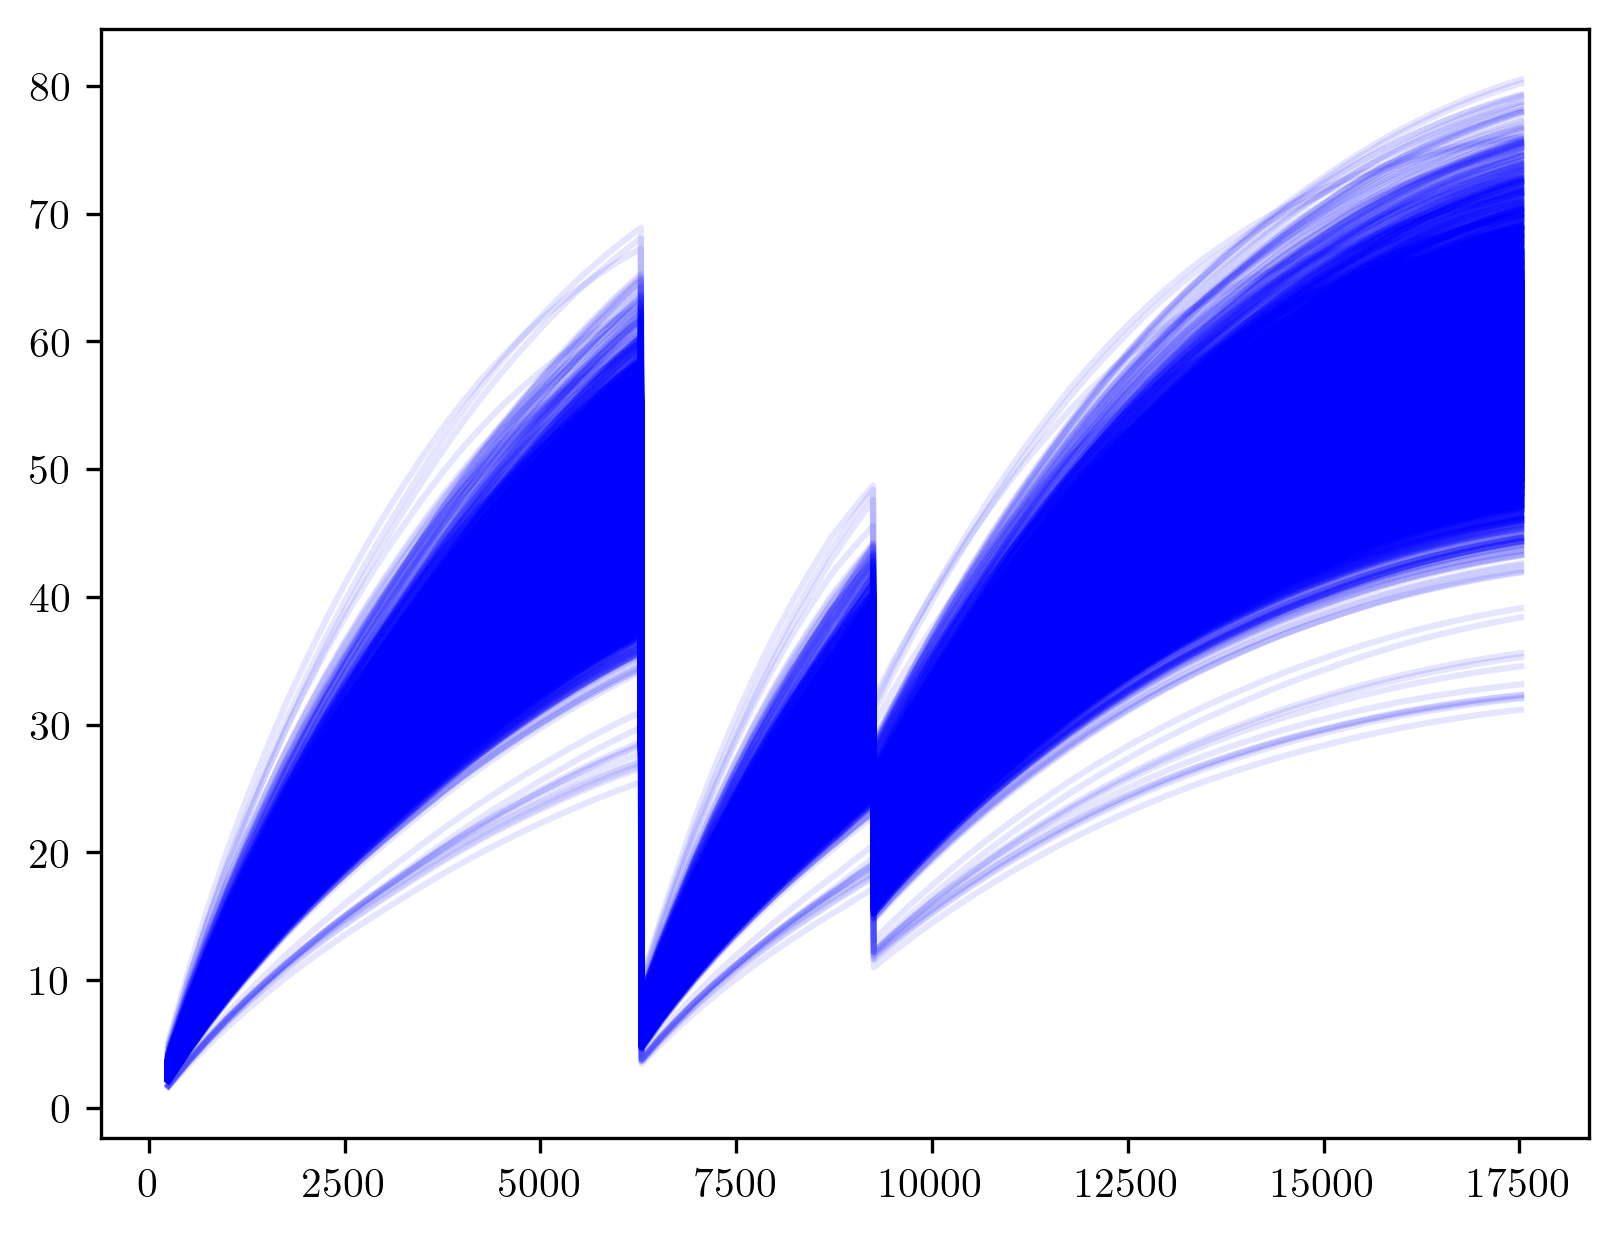

In [16]:
for i in range(10000):
    plt.plot(SIMULATION_TIME, traj[i,:], color='blue', alpha=0.1)

In [21]:
posterior_samples = np.asarray([np.asarray(marginals[i].getSample(100000)).reshape(-1) for i in range(len(marginals))])
posterior_distrib_df = pd.DataFrame(posterior_samples.T, columns=['X'+str(i) for i in range(1,8)])


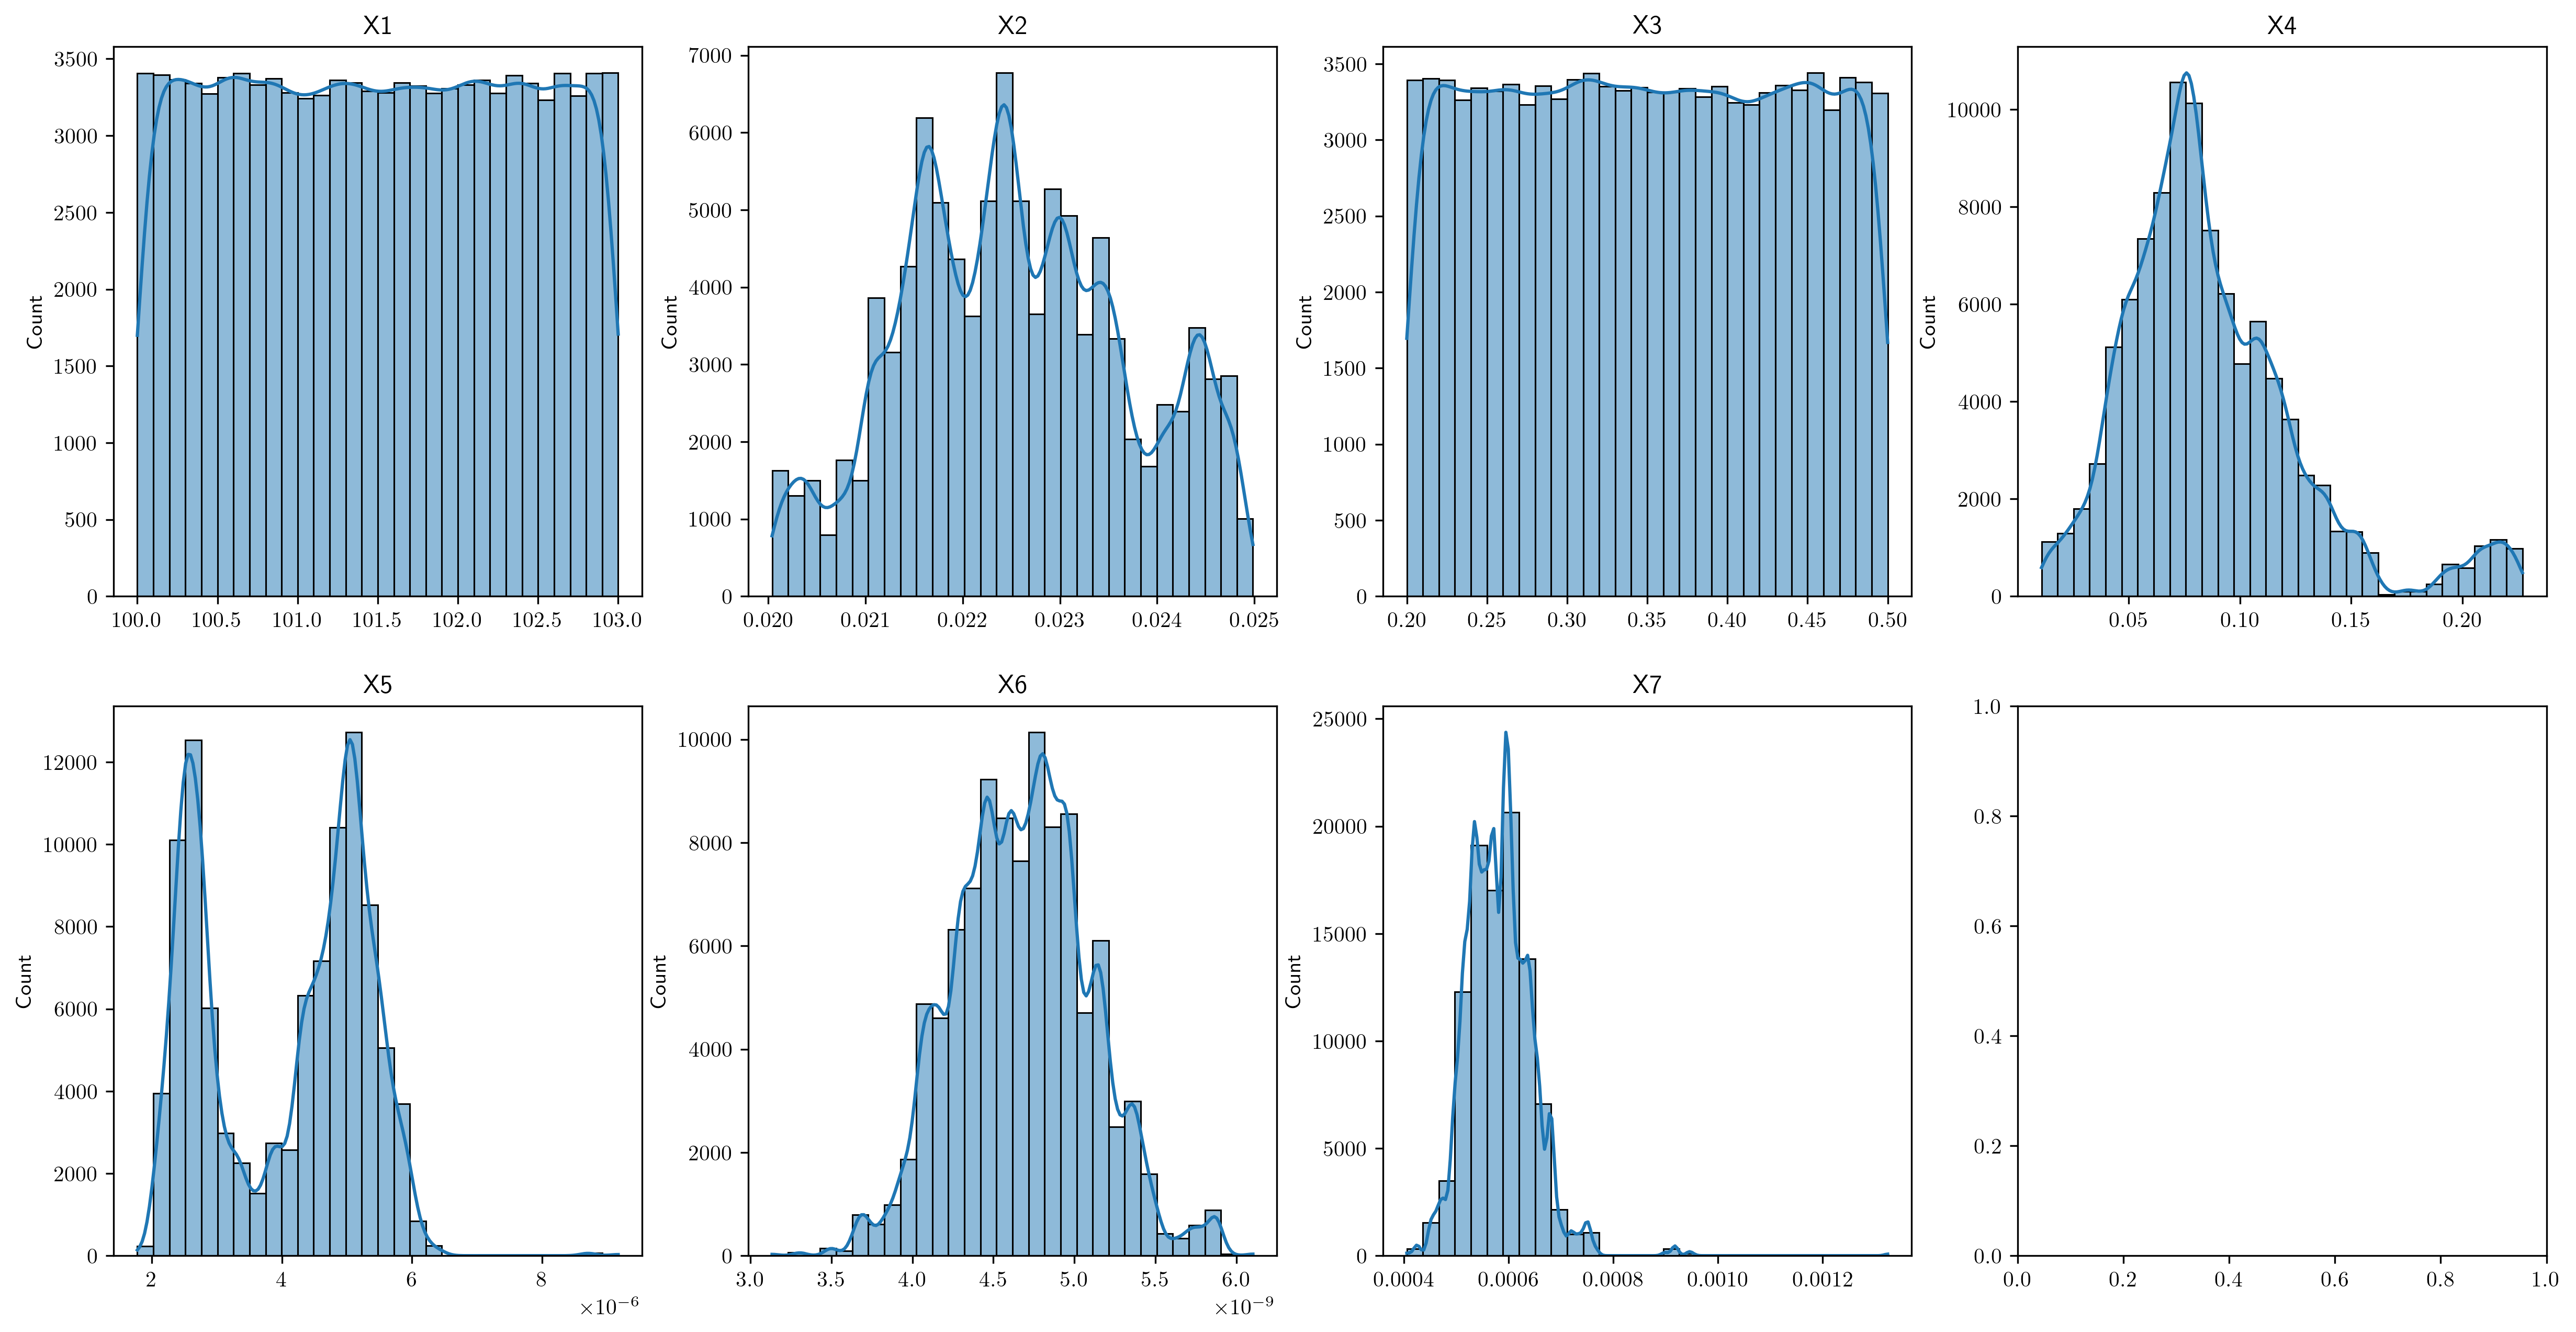

In [22]:
fig, axs = plt.subplots(2, 4, figsize=(20,10))

for i in range(7):
    sns.histplot(posterior_samples[i], ax=axs[i//4, i%4], bins=30, kde=True)
    axs[i//4, i%4].set_title('X'+str(i+1))